In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

import datasets
from tqdm.notebook import tqdm

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding
)

In [3]:
MODEL_PATH =  "/home/modaresi/projects/globenc_analysis/outputs/models/output_mnli_bert-base-uncased_0001_SEED0042/checkpoint-61360"
# MODEL_PATH = "/home/modaresi/projects/globenc_analysis/outputs/models/output_sst2_bert-large-uncased_0001_SEED0042/checkpoint-10525"

TASK = "mnli"
 
SET = "validation_matched"  # train/validation/validation_matched

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [4]:
GLUE_TASKS = ["cola", "mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]

BATCH_SIZE = 32
MAX_LENGTH = 128

actual_task = "mnli" if TASK == "mnli-mm" else TASK
dataset = datasets.load_dataset("glue", actual_task)
metric = datasets.load_metric('glue', actual_task)
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
SENTENCE1_KEY, SENTENCE2_KEY = task_to_keys[TASK]
dataset

Reusing dataset glue (/opt/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [5]:
def preprocess_function_wrapped(tokenizer):
    def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[SENTENCE1_KEY],) if SENTENCE2_KEY is None else (examples[SENTENCE1_KEY], examples[SENTENCE2_KEY])
        )
        result = tokenizer(*args, padding=False, max_length=MAX_LENGTH, truncation=True)
        return result
    return preprocess_function

def token_id_to_tokens_mapper(tokenizer, sample):
    length = len(sample["input_ids"])
    return tokenizer.convert_ids_to_tokens(sample["input_ids"])[:length], length

def load_globenc(path, no_cls=False, no_sep=False):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    if no_cls:
        data["tokens"] = [d[1:] for d in data["tokens"]]
        data["globenc"] = [np.array(d)[:, 1:] for d in data["globenc"]]
    if no_sep:
        data["tokens"] = [d[:-1] for d in data["tokens"]]
        data["globenc"] = [np.array(d)[:, :-1] for d in data["globenc"]]
    data = pd.DataFrame(data)
    before_size = len(data)
    data = data[data["tokens"].map(len) > 1]
    after_size = len(data)
    print(f"Read {path}: {before_size}->{after_size} ")
    return data.to_dict(orient="list"), data.index

def load_pickle(path, no_cls=False, no_sep=False):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
model.to(torch.device("cuda:0"))
model.eval()

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, use_fast=True, max_length=MAX_LENGTH)

sel_dataset = dataset[SET].map(preprocess_function_wrapped(tokenizer), batched=True, batch_size=1024)
dataset_size = len(sel_dataset)
print(dataset_size)

Parameter 'function'=<function preprocess_function_wrapped.<locals>.preprocess_function at 0x7fb4403a0560> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/10 [00:00<?, ?ba/s]

9815


In [7]:
import pickle
import pandas as pd
HTAs_dir = "/home/modaresi/projects/globenc_analysis/outputs/HTAs"
globencs_full_dir = "/home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise_full"
globencs_v2_dir = "/home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise"
globencs_dir = "/home/modaresi/projects/globenc_analysis/outputs/globencs"
saliencies_dir = "/home/modaresi/projects/globenc_analysis/outputs/saliencies"
configs = {
    "mnli-val": {
        "hta_path": lambda epoch : f"{HTAs_dir}/mnli_validation_matched_bert-base-uncased_0001_SEED0042_checkpoint-{epoch*12272}.pkl",
        "globenc_path": lambda epoch : f"{globencs_dir}/mnli-e{epoch}_validation_matched_bert-base-uncased.pickle",
        "globenc_v2_path": lambda epoch : f"{globencs_v2_dir}/mnli-e{epoch}_validation_matched_bert-base-uncased.pickle",
        "globenc_full_path": lambda epoch : f"{globencs_full_dir}/mnli-e{epoch}_validation_matched_bert-base-uncased.pickle",
        "saliency_path": lambda epoch : f"{saliencies_dir}/mnli_bert-base-uncased_0001_SEED0042_checkpoint-{epoch*12272}.npy",
        "hf_ds": "mnli",
    },
    "sst2-val": {
        "hta_path": lambda epoch : f"{HTAs_dir}/sst2_validation_bert-base-uncased_0001_SEED0042_checkpoint-{epoch*2105}.pkl",
        "globenc_path": lambda epoch : f"{globencs_dir}/sst2-e{epoch}_validation_bert-base-uncased.pickle",
        "globenc_v2_path": lambda epoch : f"{globencs_v2_dir}/sst2-e{epoch}_validation_bert-base-uncased.pickle",
        "globenc_full_path": lambda epoch : f"{globencs_full_dir}/mnli-e{epoch}_validation_matched_bert-base-uncased.pickle",
        "saliency_path": lambda epoch : f"{saliencies_dir}/sst2_bert-base-uncased_0001_SEED0042_checkpoint-{epoch*2105}.npy",
        "hf_ds": "mnli",
    }
}

CONFIG_NAME = "mnli-val"
CONFIG = configs[CONFIG_NAME]
EPOCH = 5

In [8]:
globencs, DATASET_KEEP_IDX = load_globenc(CONFIG["globenc_path"](EPOCH), no_cls=False, no_sep=False)
globencs_v2, DATASET_KEEP_IDX = load_globenc(CONFIG["globenc_v2_path"](EPOCH), no_cls=False, no_sep=False)
globencs_full, DATASET_KEEP_IDX = load_globenc(CONFIG["globenc_full_path"](EPOCH), no_cls=False, no_sep=False)
htas = load_pickle(CONFIG["hta_path"](EPOCH))
saliencies = np.load(CONFIG["saliency_path"](EPOCH))

Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e5_validation_matched_bert-base-uncased.pickle: 9815->9815 
Read /home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise/mnli-e5_validation_matched_bert-base-uncased.pickle: 9815->9815 
Read /home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise_full/mnli-e5_validation_matched_bert-base-uncased.pickle: 9815->9815 


In [ ]:
results = {}
INVERTED = True
MASK = True
for exp_type in ["hta", "globencV1", "globencV2", "globencFull", "salsNorm"]:
    results[exp_type] = []
    for i in tqdm(range(11)):
        # Masks i*10% of the tokens -- based on their attribution metric value
        def mapping_masks(example):
            length = np.sum(example["attention_mask"])
            if exp_type == "globencV1":
                sal_rank = globencs['globenc'][example["idx"]][0][:length].argsort()
            elif exp_type == "globencV2":
                sal_rank = globencs_v2['globenc'][example["idx"]][0][:length].argsort()
            elif exp_type == "globencFull":
                sal_rank = globencs_full['globenc'][example["idx"]][0][:length].argsort()
            elif exp_type == "salsNorm":
                sal_rank = saliencies[example["idx"]][:length].argsort()
            elif exp_type == "hta":
                sal_rank = htas["HTAs"][example["idx"]][0][:length].argsort()
            # Exclude CLS and SEPs
            sal_rank = sal_rank[~np.in1d(sal_rank, np.argwhere(np.array(example["input_ids"]) < 103).flatten())]
            mask_count = int(np.floor(len(sal_rank) * i / 10.0))
            if mask_count == 0:
                masks = []
            else:
                if INVERTED:
                    masks = sal_rank[-mask_count:]
                else:
                    masks = sal_rank[:mask_count]
            replacement_token = tokenizer.mask_token_id if MASK else tokenizer.pad_token_id
            if not MASK:
                example["attention_mask"] = [0 if j in masks else example["attention_mask"][j] for j in range(length)]
            example["input_ids"] = [replacement_token if j in masks else example["input_ids"][j] for j in range(length)]
            return example
        
        modified_set = sel_dataset.map(mapping_masks)

        modified_set.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
        collator = DataCollatorWithPadding(tokenizer, True, MAX_LENGTH, return_tensors="pt")
        dataloader = torch.utils.data.DataLoader(modified_set, batch_size=BATCH_SIZE, collate_fn=collator)
        steps = int(np.ceil(dataset_size / BATCH_SIZE))
        num_labels = len(set(modified_set['label']))

        it = iter(dataloader)
        y_preds = torch.zeros(size=(dataset_size,)).cuda()
        y_trues = torch.zeros(size=(dataset_size,), dtype=torch.int32).cuda()

        with torch.no_grad():
            for i in tqdm(range(steps)):
                batch = next(it)
                batch = {k: v.to(torch.device('cuda:0')) for k, v in batch.items()}
                inputs = {
                    'input_ids': batch['input_ids'],
                    'attention_mask': batch['attention_mask'],
                    'token_type_ids': batch['token_type_ids'],
                }
                y_trues[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = batch['labels']
                output = model(**batch)
                y_preds[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = torch.argmax(output.logits, dim=-1)
        
        results[exp_type].append((y_trues == y_preds).cpu().numpy())
        # print(results[exp_type][-1])

  0%|          | 0/11 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

/home/modaresi/.conda/envs/globenc-venv/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/307 [00:00<?, ?it/s]

In [11]:
lengths = np.array([len(sel_dataset[i]["input_ids"]) for i in range(dataset_size)])

6 128.0


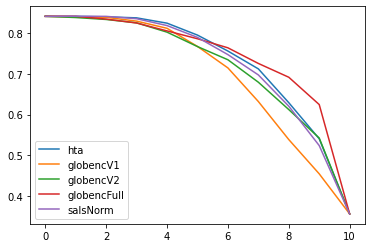

In [12]:
# MNLI - MASK - Length based - Less important removal
import matplotlib.pyplot as plt
def partial_plot(p1, p2):
    q1 = np.quantile(lengths, p1)
    q2 = np.quantile(lengths, p2)
    print(q1, q2)
    aargs = np.argwhere((lengths >= q1) * (lengths < q2))
    for exp_type in ["hta", "globencV1", "globencV2", "globencFull","salsNorm"]:
        plt.plot([np.mean(results[exp_type][i][aargs]) for i in range(11)], label=exp_type)
    plt.legend()
    plt.show()
partial_plot(0, 1.0)

6 26.0


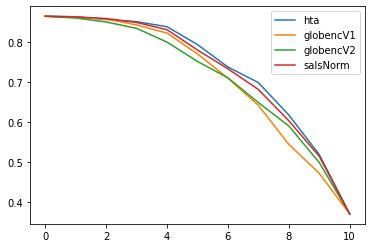

26.0 36.0


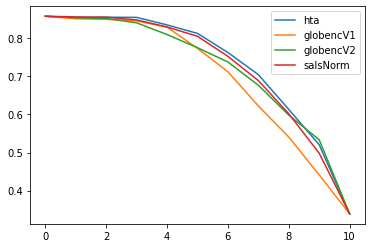

36.0 49.0


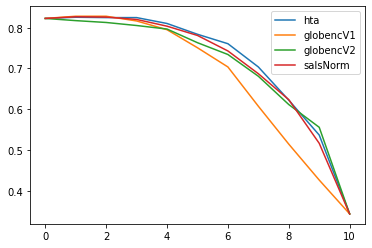

49.0 128.0


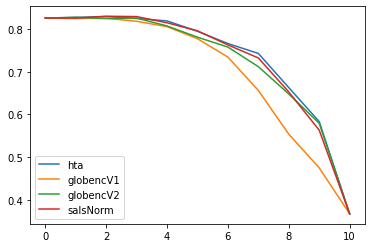

In [31]:
# MNLI - MASK - Length based - less important removal
import matplotlib.pyplot as plt
def partial_plot(p1, p2):
    q1 = np.quantile(lengths, p1)
    q2 = np.quantile(lengths, p2)
    print(q1, q2)
    aargs = np.argwhere((lengths >= q1) * (lengths < q2))
    for exp_type in ["hta", "globencV1", "globencV2", "salsNorm"]:
        plt.plot([np.mean(results[exp_type][i][aargs]) for i in range(11)], label=exp_type)
    plt.legend()
    plt.show()
partial_plot(0, 0.25)
partial_plot(0.25, 0.5)
partial_plot(0.5, 0.75)
partial_plot(0.75, 1.0)

6 26.0


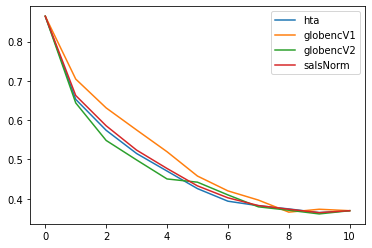

26.0 36.0


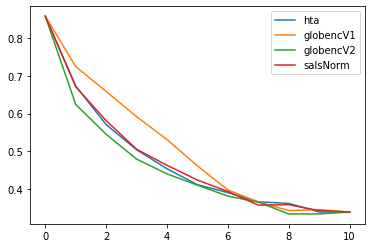

36.0 49.0


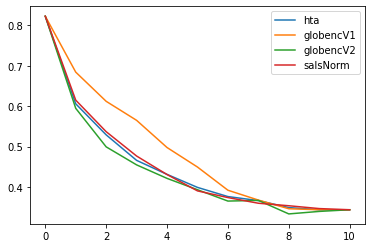

49.0 128.0


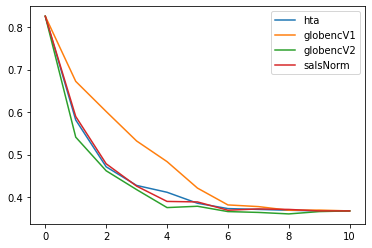

In [29]:
# MNLI - MASK - Length based - important removal
import matplotlib.pyplot as plt
def partial_plot(p1, p2):
    q1 = np.quantile(lengths, p1)
    q2 = np.quantile(lengths, p2)
    print(q1, q2)
    aargs = np.argwhere((lengths >= q1) * (lengths < q2))
    for exp_type in ["hta", "globencV1", "globencV2", "salsNorm"]:
        plt.plot([np.mean(results[exp_type][i][aargs]) for i in range(11)], label=exp_type)
    plt.legend()
    plt.show()
partial_plot(0, 0.25)
partial_plot(0.25, 0.5)
partial_plot(0.5, 0.75)
partial_plot(0.75, 1.0)

4 17.0


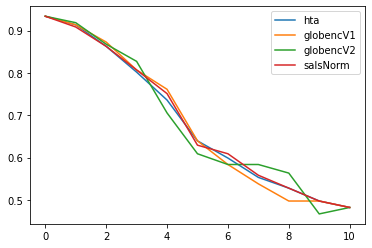

17.0 24.5


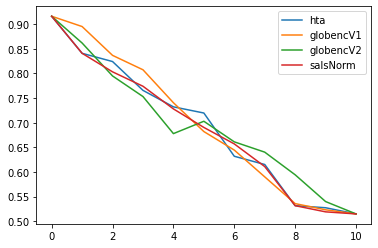

24.5 32.0


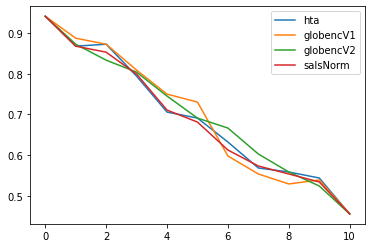

32.0 55.0


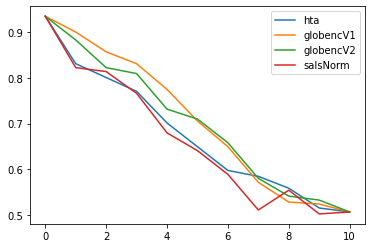

In [19]:
# SST2 - MASK - Length based - important removal
import matplotlib.pyplot as plt
def partial_plot(p1, p2):
    q1 = np.quantile(lengths, p1)
    q2 = np.quantile(lengths, p2)
    print(q1, q2)
    aargs = np.argwhere((lengths >= q1) * (lengths < q2))
    for exp_type in ["hta", "globencV1", "globencV2", "salsNorm"]:
        plt.plot([np.mean(results[exp_type][i][aargs]) for i in range(11)], label=exp_type)
    plt.legend()
    plt.show()
partial_plot(0, 0.25)
partial_plot(0.25, 0.5)
partial_plot(0.5, 0.75)
partial_plot(0.75, 1.0)

4 17.0


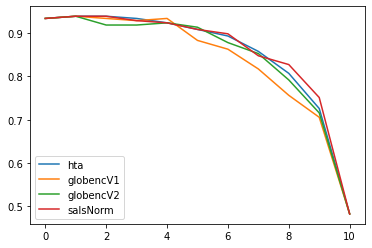

17.0 24.5


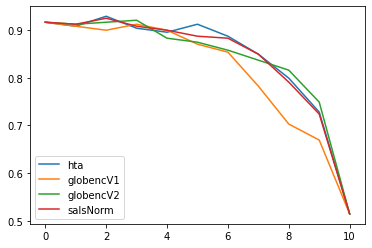

24.5 32.0


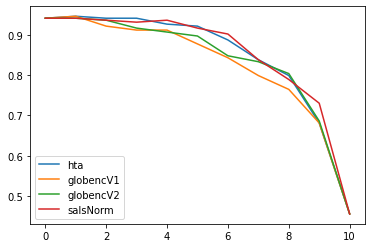

32.0 55.0


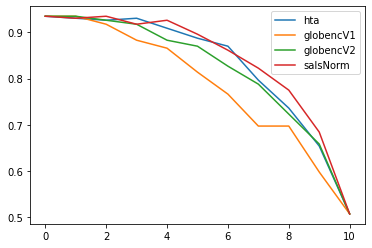

In [17]:
# SST2 - MASK - Length based - Less important removal
import matplotlib.pyplot as plt
def partial_plot(p1, p2):
    q1 = np.quantile(lengths, p1)
    q2 = np.quantile(lengths, p2)
    print(q1, q2)
    aargs = np.argwhere((lengths >= q1) * (lengths < q2))
    for exp_type in ["hta", "globencV1", "globencV2", "salsNorm"]:
        plt.plot([np.mean(results[exp_type][i][aargs]) for i in range(11)], label=exp_type)
    plt.legend()
    plt.show()
partial_plot(0, 0.25)
partial_plot(0.25, 0.5)
partial_plot(0.5, 0.75)
partial_plot(0.75, 1.0)

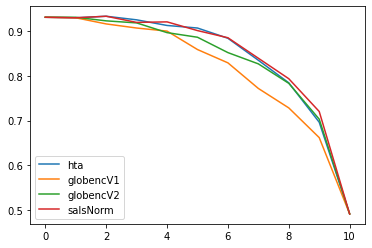

In [14]:
# sst2 - Mask token replacement - Less Important removal first
import matplotlib.pyplot as plt
for exp_type in ["hta", "globencV1", "globencV2", "salsNorm"]:
    plt.plot(results[exp_type], label=exp_type)
plt.legend()
plt.show()

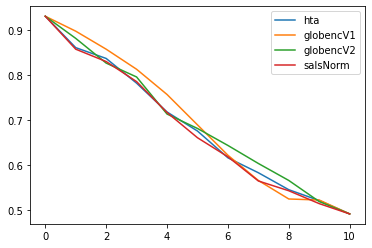

In [12]:
# sst2 - Mask token replacement - Important removal first
import matplotlib.pyplot as plt
for exp_type in ["hta", "globencV1", "globencV2", "salsNorm"]:
    plt.plot(results[exp_type], label=exp_type)
plt.legend()
plt.show()

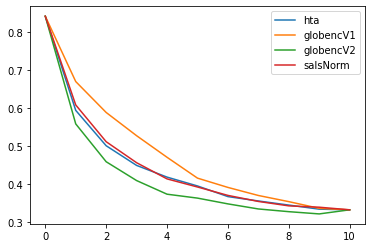

In [17]:
# All - Pad token replacement
import matplotlib.pyplot as plt
for exp_type in ["hta", "globencV1", "globencV2", "salsNorm"]:
    plt.plot(results[exp_type], label=exp_type)
plt.legend()
plt.show()

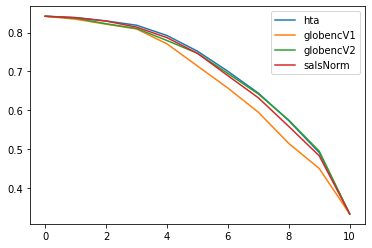

In [15]:
# All - Pad token replacement
import matplotlib.pyplot as plt
for exp_type in ["hta", "globencV1", "globencV2", "salsNorm"]:
    plt.plot(results[exp_type], label=exp_type)
plt.legend()
plt.show()

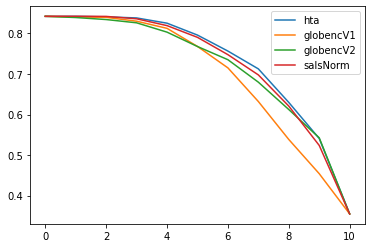

In [15]:
# All - Mask token replacement
import matplotlib.pyplot as plt
for exp_type in ["hta", "globencV1", "globencV2", "salsNorm"]:
    plt.plot(results[exp_type], label=exp_type)
plt.legend()
plt.show()

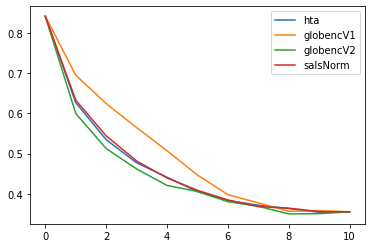

In [17]:
# All - Mask token replacement
import matplotlib.pyplot as plt
for exp_type in ["hta", "globencV1", "globencV2", "salsNorm"]:
    plt.plot(results[exp_type], label=exp_type)
plt.legend()
plt.show()

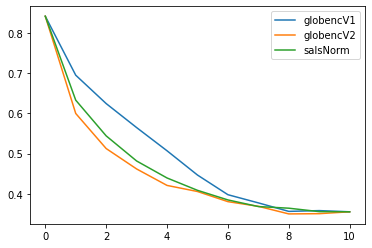

In [23]:
# All
import matplotlib.pyplot as plt
for exp_type in ["globencV1", "globencV2", "salsNorm"]:
    plt.plot(results[exp_type], label=exp_type)
plt.legend()
plt.show()

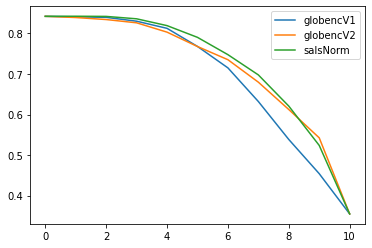

In [25]:
# All
import matplotlib.pyplot as plt
for exp_type in ["globencV1", "globencV2", "salsNorm"]:
    plt.plot(results[exp_type], label=exp_type)
plt.legend()
plt.show()

In [8]:
results = {}
for exp_type in ["globencV1", "globencV2", "salsNorm"]:
    results[exp_type] = np.zeros((11, dataset_size))
    for i in tqdm(range(11)):
        # Masks i*10% of the tokens -- based on their attribution metric value
        def mapping_masks(example):
            length = np.sum(example["attention_mask"])
            if exp_type == "globencV1":
                sal_rank = globencs['globenc'][example["idx"]][0][:length].argsort()
            elif exp_type == "globencV2":
                sal_rank = globencs_v2['globenc'][example["idx"]][0][:length].argsort()
            elif exp_type == "salsNorm":
                sal_rank = saliencies[example["idx"]][:length].argsort()
            # Exclude CLS and SEPs
            sal_rank = sal_rank[~np.in1d(sal_rank, np.argwhere(np.array(example["input_ids"]) < 103).flatten())]
            mask_count = int(np.floor(len(sal_rank) * i / 10.0))
            if mask_count == 0:
                masks = []
            else:
                masks = sal_rank[-mask_count:]
            example["input_ids"] = [tokenizer.mask_token_id if j in masks else example["input_ids"][j] for j in range(length)]
            return example
        
        modified_set = sel_dataset.map(mapping_masks)
        num_labels = len(set(modified_set['label']))

        modified_set.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
        collator = DataCollatorWithPadding(tokenizer, True, MAX_LENGTH, return_tensors="pt")
        dataloader = torch.utils.data.DataLoader(modified_set, batch_size=BATCH_SIZE, collate_fn=collator)
        steps = int(np.ceil(dataset_size / BATCH_SIZE))

        softmax_fn = torch.nn.Softmax(dim=-1)

        it = iter(dataloader)

        with torch.no_grad():
            for k in range(steps):
                batch = next(it)
                batch = {k: v.to(torch.device('cuda:0')) for k, v in batch.items()}
                inputs = {
                    'input_ids': batch['input_ids'],
                    'attention_mask': batch['attention_mask'],
                    'token_type_ids': batch['token_type_ids'],
                }
                labels = batch['labels']
                output = model(**batch)
                y_probs = softmax_fn(output.logits)        
                results[exp_type][i, k*BATCH_SIZE:(k+1)*BATCH_SIZE] = torch.gather(y_probs, 1, labels.unsqueeze(-1)).cpu().numpy().flatten()
                
        print(np.mean(results[exp_type][i]))

  0%|          | 0/11 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

/home/modaresi/.conda/envs/globenc-venv/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


0.8381161942075297


0ex [00:00, ?ex/s]

0.691603848687971


0ex [00:00, ?ex/s]

0.6192670218630143


0ex [00:00, ?ex/s]

0.5582802812522952


0ex [00:00, ?ex/s]

0.49941275297986193


0ex [00:00, ?ex/s]

0.43745500662733194


0ex [00:00, ?ex/s]

0.39273008616153


0ex [00:00, ?ex/s]

0.37182395606452745


0ex [00:00, ?ex/s]

0.3539102403897867


0ex [00:00, ?ex/s]

0.35270577512378554


0ex [00:00, ?ex/s]

0.3521960157345985


  0%|          | 0/11 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

0.8381161942075297


0ex [00:00, ?ex/s]

0.5948423413885285


0ex [00:00, ?ex/s]

0.5089555310609225


0ex [00:00, ?ex/s]

0.4555253722839799


0ex [00:00, ?ex/s]

0.4200749015155869


0ex [00:00, ?ex/s]

0.4009917911717323


0ex [00:00, ?ex/s]

0.37766908342389305


0ex [00:00, ?ex/s]

0.363067638652595


0ex [00:00, ?ex/s]

0.3491382836693307


0ex [00:00, ?ex/s]

0.3488868277132414


0ex [00:00, ?ex/s]

0.3521960157345985


  0%|          | 0/11 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

0.8381161942075297


0ex [00:00, ?ex/s]

0.628561861995663


0ex [00:00, ?ex/s]

0.5379869016579781


0ex [00:00, ?ex/s]

0.4730351939724931


0ex [00:00, ?ex/s]

0.4351140595819354


0ex [00:00, ?ex/s]

0.40187468202815346


0ex [00:00, ?ex/s]

0.37958048047986304


0ex [00:00, ?ex/s]

0.3651601308595057


0ex [00:00, ?ex/s]

0.3584530524626316


0ex [00:00, ?ex/s]

0.3526974313511569


0ex [00:00, ?ex/s]

0.3521960157345985


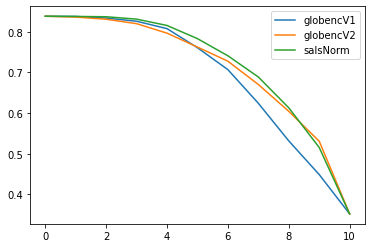

In [25]:
# All
import matplotlib.pyplot as plt
for exp_type in ["globencV1", "globencV2", "salsNorm"]:
    plt.plot(np.mean(results[exp_type], axis=-1), label=exp_type)
plt.legend()
plt.show()

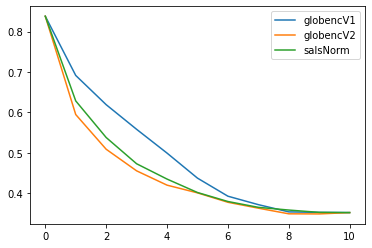

In [9]:
# All
import matplotlib.pyplot as plt
for exp_type in ["globencV1", "globencV2", "salsNorm"]:
    plt.plot(np.mean(results[exp_type], axis=-1), label=exp_type)
plt.legend()
plt.show()

In [ ]:
idx = 123
for exp_type in ["globencV1", "globencV2", "salsNorm"]:
    plt.plot(results[exp_type][:, idx], label=exp_type)
plt.legend()
plt.show()